In [36]:
import tensorflow as tf
import numpy as np
import seaborn
import matplotlib.pyplot as plt
% pylab inline

Populating the interactive namespace from numpy and matplotlib


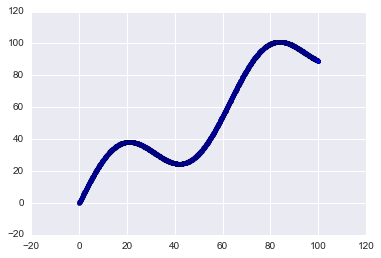

In [37]:
# Define input data
X_data = np.arange(100, step=.1)
y_data = X_data + 20 * np.sin(X_data/10)
# Plot input data
plt.scatter(X_data, y_data)

In [51]:
# Define data size and batch size
n_samples = 1000
batch_size = 100
# Tensorflow is finicky about shapes, so resize
X_data = np.reshape(X_data, (n_samples,1))
y_data = np.reshape(y_data, (n_samples,1))
# Define placeholders for input
X = tf.placeholder(tf.float32, shape=(batch_size, 1))
y = tf.placeholder(tf.float32, shape=(batch_size, 1)) 

In [52]:
with tf.variable_scope("linear-regression", reuse=True):
    W = tf.get_variable("weights", (1, 1),
    initializer=tf.random_normal_initializer())
    b = tf.get_variable("bias", (1,),
    initializer=tf.constant_initializer(0.0))
    y_pred = tf.matmul(X, W) + b
    loss = tf.reduce_sum((y - y_pred)**2/n_samples)

In [59]:
opt = tf.train.AdamOptimizer()
opt_operation = opt.minimize(loss)

In [70]:
opt_operation = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    # Initialize Variables in graph
    sess.run(tf.initialize_all_variables())
    # Gradient descent loop for 500 steps
    for _ in range(500):
        # Select random minibatch
        indices = np.random.choice(n_samples, batch_size)
        X_batch, y_batch = X_data[indices], y_data[indices]
        # Do gradient descent step
        _, loss_val = sess.run([opt_operation, loss], feed_dict={X: X_batch, y: y_batch})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### RANK NET

In [233]:
#### -------------> Import data:

def readDataset(path):
    '''
    Dataset - LETOR 4.0
    Dataset format: svmlight / libsvm format
    <label> <feature-id>:<feature-value>... #docid = <feature-value> inc = <feature-value> prob = <feature-value>
    We have a total of 46 features
    '''

    X_train = [] #<feature-value>[46]
    y_train = [] #<label>
    Query = []   #<query-id><document-id><inc><prob>

    print('Reading training data from file...')

    with open(path, 'r') as file:
        for line in file:
            split = line.split()
            y_train.append(int(split[0]))
            X_train.append(extractFeatures(split))
            Query.append(extractQueryData(split))
    print('Read %d lines from file...' %(len(X_train)))
    return (X_train, y_train, Query)

def extractFeatures(split):
    '''
    Extract the query to document features used
    as input to the neural network
    '''
    features = []
    for i in xrange(2, 138):
        features.append(float(split[i].split(':')[1]))
    return features

def extractQueryData(split):
    '''
    Extract the query features from a dataset line
    Format:
    <query-id><document-id><inc><prob>
    '''
    queryFeatures = [split[1].split(':')[1]]

    return queryFeatures

def extractPairsOfRatedSites(y_train, Query):
    '''
    For each queryid, extract all pairs of documents
    with different relevance judgement and save them in
    a list with the most relevant in position 0
    '''
    pairs = []
    for i in xrange(0, len(Query)):
        for j in xrange(i+1, len(Query)):
            #Only look at queries with the same id
            if(Query[i] != Query[j]):
                break
            #Document pairs found with different rating
            if(Query[i] == Query[j] and y_train[i] != y_train[j]):
                #Sort by saving the largest index in position 0
                if(y_train[i] > y_train[j]):
                    pairs.append([i, j])
                else:
                    pairs.append([j, i])
    print('Found %d document pairs' %(len(pairs)))
    return pairs

def separate_training(X,pairs):
    data1=[]
    data2=[]
    for i in pairs:
        data1.append(X[i[0]])
        data2.append(X[i[0]])
    return np.array(data1),np.array(data2)





In [234]:
#Read training data
X_train, y_train, Query = readDataset('./MSLR-WEB10K/Fold1/train.txt')

len_train=500
X_train1,y_train1=X_train[0:len_train],y_train[0:len_train]
Query1=Query[0:len_train]
# Extract document pairs
pairs1 = extractPairsOfRatedSites(y_train1, Query1)
X_array=np.array(X_train)
data1,data2=separate_training(X_array,pairs1)

Reading training data from file...
Read 723412 lines from file...
Found 11379 document pairs


In [235]:
nDim=data1.shape[1]
N=data1.shape[0]
first_layer=10
output_layer=1
A = tf.placeholder(tf.float32, [None, nDim])
B = tf.placeholder(tf.float32, [None, nDim])

In [236]:
P_AB = tf.placeholder(tf.float32, [None, 1])
P_true = tf.placeholder(tf.float32, [None, 1])

In [237]:
weights1 = tf.Variable(tf.zeros([nDim, first_layer]))
biases1 = tf.Variable(tf.zeros([first_layer]))

In [238]:
hiddenA = tf.matmul(A, weights1) + biases1
hiddenB = tf.matmul(B, weights1) + biases1

In [239]:
act_hiddenA = tf.nn.sigmoid(hiddenA)
act_hiddenB = tf.nn.sigmoid(hiddenB)

In [240]:
weights2 = tf.Variable(tf.zeros([first_layer,output_layer]))
biases2 = tf.Variable(tf.zeros([output_layer]))

In [241]:
outputA = tf.matmul(act_hiddenA, weights2) + biases2
outputB = tf.matmul(act_hiddenB, weights2) + biases2

In [242]:
Oi = tf.nn.sigmoid(outputA)
Oj = tf.nn.sigmoid(outputB)
Oij=Oi-Oj

In [243]:
Pij=tf.exp(Oij)/(1+tf.exp(Oij))

In [244]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Pij,
                                                        labels=P_true)

In [245]:
cost = tf.reduce_mean(cross_entropy)

In [246]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [247]:
session = tf.Session()

In [248]:
session.run(tf.global_variables_initializer())

In [249]:
batch_size = 100

In [250]:
target=np.ones([data1.shape[0],1])

In [253]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
#        A_batch, y_true_batch = data.train.next_batch(batch_size)
        indices = np.random.choice(data1.shape[0], 100)
        A_batch, B_batch, target_batch = data1[indices], data2[indices] , target[indices]
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        #
        #feed_dict_train = {A: data1,B:data2, P_true: target} --> working
        feed_dict_train = {A: A_batch,B:B_batch, P_true: target_batch} 
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [254]:
optimize(num_iterations=10)

In [ ]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))